# Equação de Calor
----

## Bibliotecas

Utilizaremos o DeepXDE junto com PyTorch para resolver estas equações.

In [1]:
import torch
import deepxde as dde
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Para reprodução dos experimentos
dde.config.set_random_seed(1000)

## Modelo equação de calor

$$
\frac{\partial u}{\partial t}(x,t) - \alpha \frac{\partial^2 u}{\partial x^2}(x,t) = f(x,t), \quad x \in (0,\ell), \ t> 0
$$

In [3]:
a = 1

In [4]:
def pde(x, y):
    dy_dt = dde.grad.jacobian(y, x, i=0, j=1)
    dy_dxx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_dt - a * dy_dxx

## Limites

$$
x \in (0,\ell), \ t> 0
$$

In [5]:
L = 1
n = 1

In [6]:
t0, tf = 0, 1

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(t0, tf)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Condições de contorno e iniciais

In [7]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

## Solução Exata

$$
u(x,t) = e^{\frac{-\alpha \pi^2 t}{\ell}} \sin \Big( \frac{\pi x}{\ell} \Big)
$$

In [8]:
def exact_solution(X):
    x, t = X[:,0], X[:,1]
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)

## Dados de treinamento

In [9]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2500,
    num_boundary=80,
    num_initial=160,
    num_test=150
)

## Otimizando a rede

In [10]:
n_hidden_layers = [1, 2, 3, 4, 5, 6]
n_nodes_per_layer = [10, 20, 40]

# n_hidden_layers = [1]
# n_nodes_per_layer = [10]

In [11]:
def create_test_points(nop):
    
    X = np.linspace(0, L, nop)
    Y = np.linspace(t0, tf, nop)
    
    X, Y = np.meshgrid(X, Y)
    XY = np.vstack((X.flatten(), Y.flatten())).T

    return X, Y, XY

In [12]:
nop = 50
_, _, test_points = create_test_points(nop)

table = []

for n_hidden_l in n_hidden_layers:
    for n_nodes in n_nodes_per_layer:
        
        net = dde.nn.FNN([2] + [n_nodes] * n_hidden_l + [1], "tanh", "Glorot normal")
        model = dde.Model(data, net)
        
        model.compile("adam", lr=1e-3)
    
        losshistory, train_state = model.train(
            iterations=20000, 
            model_save_path=f"../modelos/heat_{n_nodes}x{n_hidden_l}")

        exact = exact_solution(test_points).reshape((nop, nop))
        pinns = model.predict(test_points).reshape((nop, nop))
        
        l_infinity = scipy.linalg.norm(exact - pinns, ord=np.inf)
        
        table.append([n_hidden_l, n_nodes, l_infinity])
 

Compiling model...
'compile' took 0.768824 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.10e-02, 1.18e-01, 8.65e-01]    [9.69e-03, 1.18e-01, 8.65e-01]    []  


/home/gabriel/anaconda3/envs/ermac_2025/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [1.09e-02, 5.09e-02, 9.50e-02]    [7.35e-03, 5.09e-02, 9.50e-02]    []  
2000      [8.40e-03, 3.37e-02, 7.16e-02]    [4.18e-03, 3.37e-02, 7.16e-02]    []  
3000      [1.22e-02, 2.33e-02, 5.62e-02]    [7.99e-03, 2.33e-02, 5.62e-02]    []  
4000      [1.23e-02, 1.98e-02, 5.13e-02]    [7.67e-03, 1.98e-02, 5.13e-02]    []  
5000      [1.04e-02, 1.56e-02, 4.23e-02]    [5.99e-03, 1.56e-02, 4.23e-02]    []  
6000      [1.08e-02, 1.19e-02, 3.46e-02]    [8.26e-03, 1.19e-02, 3.46e-02]    []  
7000      [1.03e-02, 1.05e-02, 3.11e-02]    [7.91e-03, 1.05e-02, 3.11e-02]    []  
8000      [9.58e-03, 9.86e-03, 2.70e-02]    [7.36e-03, 9.86e-03, 2.70e-02]    []  
9000      [9.23e-03, 8.52e-03, 2.40e-02]    [7.04e-03, 8.52e-03, 2.40e-02]    []  
10000     [8.10e-03, 7.17e-03, 1.97e-02]    [5.76e-03, 7.17e-03, 1.97e-02]    []  
11000     [6.37e-03, 3.85e-03, 1.13e-02]    [3.63e-03, 3.85e-03, 1.13e-02]    []  
12000     [6.61e-03, 2.51e-03, 6.96e-03]    [4.31e-03, 2.51e-03, 6.96e-03]    []  
1300

In [13]:
norm_df = pd.DataFrame(table, columns=['Nº Camadas Escondidas', 'Nº Nós', 'Norm. Infinito'])

In [14]:
norm_df

,Nº Camadas Escondidas,Nº Nós,Norm. Infinito
0,1,10,2.060782
1,1,20,1.021447
2,1,40,1.215324
3,2,10,0.136274
4,2,20,0.211846
5,2,40,0.118872
6,3,10,0.101019
7,3,20,0.087010
8,3,40,0.301209
9,4,10,0.121855


## Visualizando Resultados

In [15]:
best_n_hidden_l = 4
best_n_nodes = 20

In [16]:

best_net = dde.nn.FNN([2] + [best_n_nodes] * best_n_hidden_l + [1], "tanh", "Glorot normal")
best_model = dde.Model(data, best_net)
best_model.compile("adam", lr=0.001)


Compiling model...
'compile' took 0.000116 s



In [17]:
best_model.train(iterations=20000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.03e-02, 1.20e-02, 4.55e-01]    [5.10e-02, 1.20e-02, 4.55e-01]    []  
1000      [2.47e-03, 1.21e-04, 3.62e-04]    [8.61e-04, 1.21e-04, 3.62e-04]    []  
2000      [7.87e-04, 2.86e-05, 5.75e-05]    [5.30e-04, 2.86e-05, 5.75e-05]    []  
3000      [4.75e-04, 2.52e-05, 1.70e-05]    [3.18e-04, 2.52e-05, 1.70e-05]    []  
4000      [7.03e-04, 5.83e-05, 8.89e-05]    [3.03e-04, 5.83e-05, 8.89e-05]    []  
5000      [2.06e-04, 2.34e-05, 1.15e-05]    [1.24e-04, 2.34e-05, 1.15e-05]    []  
6000      [1.19e-04, 1.78e-05, 8.93e-06]    [7.22e-05, 1.78e-05, 8.93e-06]    []  
7000      [9.13e-05, 1.54e-05, 9.40e-06]    [5.60e-05, 1.54e-05, 9.40e-06]    []  
8000      [7.46e-05, 1.43e-05, 9.40e-06]    [4.44e-05, 1.43e-05, 9.40e-06]    []  
9000      [1.52e-04, 1.71e-05, 2.44e-05]    [6.15e-05, 1.71e-05, 2.44e-05]    []  
10000     [4.33e-04, 1.25e-05, 5.52e-05]    [1.01e-04, 1.25e-

(<deepxde.model.LossHistory at 0x7fe9b71c1ca0>,
 <deepxde.model.TrainState at 0x7fe9b5bbd3a0>)

In [18]:
nop = 25
X, Y, XY = create_test_points(nop)

Z_best_model = best_model.predict(XY)
Z_exact_sol = exact_solution(XY)

Z_best_model = Z_best_model.reshape((nop, nop))
Z_exact_sol = Z_exact_sol.reshape((nop, nop))


In [19]:
def plot_3d_and_save(X, Y, Z, file_path):
 
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(Y, X, Z, vmin=Z.min() * 2, cmap="viridis")
    
    plt.xlabel("t")
    plt.ylabel("x")
    
    plt.savefig(file_path)
    plt.show()

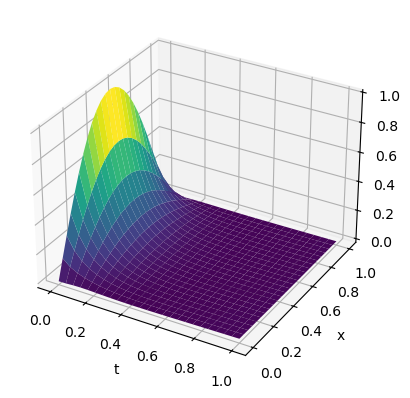

In [20]:
plot_3d_and_save(X, Y, Z_best_model, "../figuras/heat_pinns.pdf")

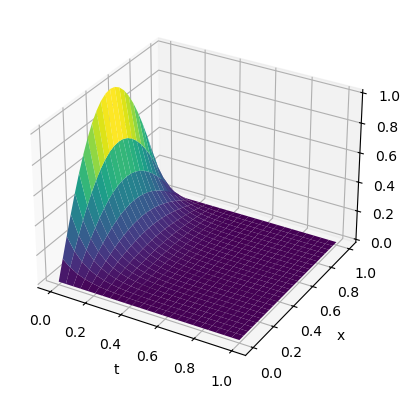

In [21]:
plot_3d_and_save(X, Y, Z_exact_sol, "../figuras/heat_exato.pdf")

## Analisando função de perda

In [22]:
def plot_and_save_losses(losshistory, file_path):
    
    X = losshistory.steps
    train = np.sum(losshistory.loss_train, axis=1)
    test = np.sum(losshistory.loss_test, axis=1)
    
    plt.semilogy(X, train, "o-", label="Treinamento", linewidth=2)
    plt.semilogy(X, test, "x-", label="Teste", linewidth=2)

    plt.xlabel("Iteração")
    plt.ylabel("Erro em escala logarítmica")
    
    plt.legend()
    plt.grid()
    plt.savefig(file_path)
    plt.show()

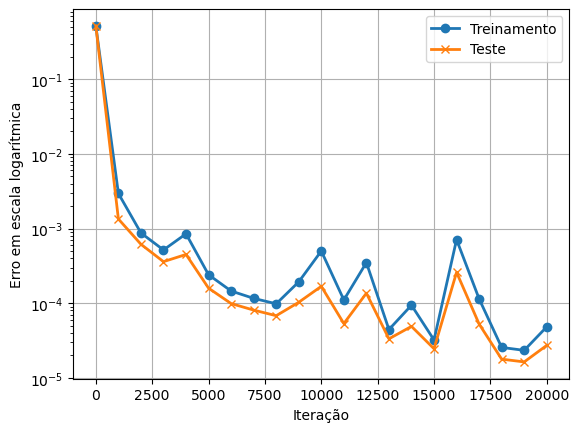

In [23]:
plot_and_save_losses(best_model.losshistory, "../figuras/heat_loss.pdf") 